## Assignment 02

### Alignment and Fitting

P. H. J. Udugamasooriya - 220658U - [GitHub](https://github.com/pulasthi-u/en3160-assignment02/tree/master)

Start by importing all required libraries.

In [108]:
import cv2
import numpy as np

from scipy.optimize import minimize
from scipy import linalg

import matplotlib.pyplot as plt

#### Question 01

We start by importing the required image in grayscale.

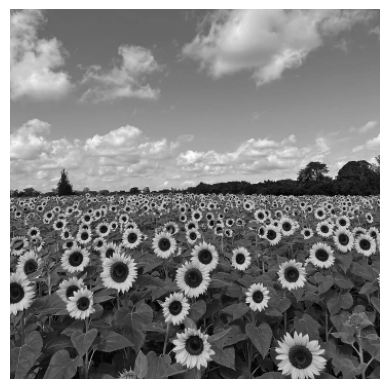

In [109]:
im = cv2.imread('the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_REDUCED_COLOR_4)
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

plt.imshow(im, cmap='gray')
plt.axis('off')
plt.show()

We will look for blobs using a Laplacian of Gaussian (LoG) kernel.

A 2D (continuous) Gaussian with zero-mean and variance $\sigma^2$ is given by
$$
G(x, y) = \dfrac{1}{2\pi\sigma^2} \exp\left(-\dfrac{x^2+y^2}{2\sigma^2}\right),
$$
and its Laplacian is given by
$$
L(x, y) = \nabla^2 \, G(x, y) = \left[ \dfrac{x^2 + y^2 - 2\sigma^2}{2\pi\sigma^6}\right] \exp\left(-\dfrac{x^2+y^2}{2\sigma^2}\right).
$$

We now implement a discrete LoG kernel.

In [110]:
def LoG_kernel(sigma, k):
    k = (k - 1) // 2

    X, Y = np.meshgrid(np.arange(-k, k+1), np.arange(-k, k+1))

    R2 = X**2 + Y**2

    log = ((R2 - 2*sigma**2) / (2*np.pi*sigma**6)) * np.exp(-R2 / (2*sigma**2))

    return log

Consider a (continuous) image $I(x, y)$ of a perfect circle with radius $R$, given by
$$
I(x, y) =
\begin{cases}
1, & x^2 + y^2 < R^2, \\
0, & \text{otherwise}.
\end{cases}
$$

It is easy to see (due to radial symmetry) that the response of the LoG kernel to such an image is
$$
2\pi \int_0^R L(x, 0) \, dx,
$$
and that this response is maximum when 
$$
\dfrac{\text{d}}{\text{d}R} \int_0^R L(x, 0) \, dx = L(R, 0) = 0,
$$
which occurs precisely when
$$
R=\sigma\sqrt{2}.
$$

Note that had the image been inverted, i.e., $0$ inside the circle and $1$ elsewhere, the LoG response would simply be a constant (area of the image) minus the same integral above. In this case, the response displays a minimum, and attains it also when $R=\sigma\sqrt{2}$.

From this observation, a LoG kernel with parameter $\sigma$ can be thought of as acting to detect blobs of "radius" $\sigma\sqrt{2}$.

To detect blobs of various radii, we construct the normalized scale-space of the image $I[x, y]$, as defined by
$$
S[x, y, \sigma] = \sigma^2 \cdot L[x, y] \ast I[x, y],
$$
where $\ast$ denotes convolution (as applied to images). We consider the local extrema of $S[x, y, \sigma]$ as potential blob centers and their corresponding radii.

We first implement a function to construct the normalized LoG scale-space of an image $I[x, y]$ over some specified values of $\sigma$.

In [111]:
def LoG_scale_space(im, sigmas):
    # Empty array to store the image at each sigma
    scale_space = np.zeros((im.shape[0], im.shape[1], len(sigmas)))

    # Normalize image to [0, 1]
    im = im.astype(np.float32) / 255.0

    # Apply LoG at each sigma and append to scale_space
    for (i, sigma) in enumerate(sigmas):
        # To capture all significant values of the LoG, create a kernel with size 6*sigma + 1 (3 sigma on each side)
        LoG_size = int(6*sigma + 1)

        # Apply a scale-normalized LoG to the image
        log = LoG_kernel(sigma, LoG_size) * (sigma**2)
        response = cv2.filter2D(im, -1, log)

        # Append the response to the scale space
        scale_space[:, :, i] = response

    return scale_space

Next, we implement a function to find local maxima of a generic 3-input function $V[x, y, z]$. Here, a point $[x, y, z]$ is considered a local maximum if $I[x, y, z]$ is strictly greater than all $K^3 - 1$ neighbors in a $K \times K$ cube centered at $[x, y, z]$. We also make sure that only maxima above a certain threshold are reported.

In [112]:
def local_maxima_3D(V, K, thresh):
    K = K // 2  # K is the full size of the neighborhood cube

    # Find dimensions; i.e., domains of the inputs
    Y, X, Z = V.shape

    # An empty array to store tuples of maxima
    maxima = []

    for z in range(K, Z - K):
        for y in range(K, Y - K):
            for x in range(K, X - K):
                # Extract the K x K x K cube centered at (x, y, z)
                cube = V[y - K:y + K + 1, x - K:x + K + 1, z - K:z + K + 1]

                # Find the maximum value in the cube
                cube_max = np.max(cube)

                # If the center of the cube equals the maximum, and is the only occurrence of the maximum, and is above some threshold, we have found a local maximum
                if (cube_max == cube[0, 0, 0]) and (np.count_nonzero(cube == cube_max) == 1) and (cube_max > thresh):
                    maxima.append((x, y, z))

    return maxima

To look for blobs in the image given, we construct the _squared_ normalized LoG scale-space of the image over some values of $\sigma$. This way, we only have to deal with non-negative values, and all extrema in the scale-space would appear as maxima, which we can detect using `local_maxima_3D`. To pick out only the most significant maxima, we also pass a suitable threshold to the function.

In [113]:
# Construct a range of sigmas
sigmas = np.arange(1, 12, 1)

# Construct the normalized LoG scale-space of the image
S = LoG_scale_space(im, sigmas)

# Square the response for each sigma for the squared normalized LoG scale-space
for i in range(len(sigmas)):
    S[:, :, i] = np.square(S[:, :, i])

# Find local maxima
maxima = local_maxima_3D(S, 3, 0.105)

We will plot the results now, and draw a circle around the detected blobs.

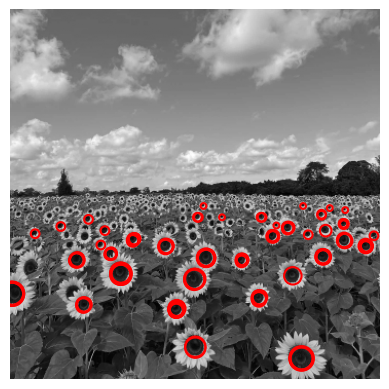

In [114]:
fig, ax = plt.subplots()
ax.imshow(im, cmap='gray')
ax.axis('off')

for blob in maxima:
    x, y, k = blob
    sigma = sigmas[k]
    ax.add_patch(plt.Circle((x, y), np.sqrt(2)*sigma, color='red', fill=False, linewidth=1.5))

plt.show()

The largest circles correspond to the greatest values of $\sigma$ that yielded a blob. We find these values in the code snippet below.

In [115]:
largest_sigma_index = np.max([k for (_, _, k) in maxima])
largest_sigma = sigmas[largest_sigma_index]

print ("Largest sigma that yielded a blob:", largest_sigma)
print ()
print ("Radius of largest detected blob:", np.sqrt(2)*largest_sigma)

Largest sigma that yielded a blob: 8

Radius of largest detected blob: 11.313708498984761


#### Question 02

We start by generating a set of noisy points belonging to a line and a circle, using the code given in the assignment:

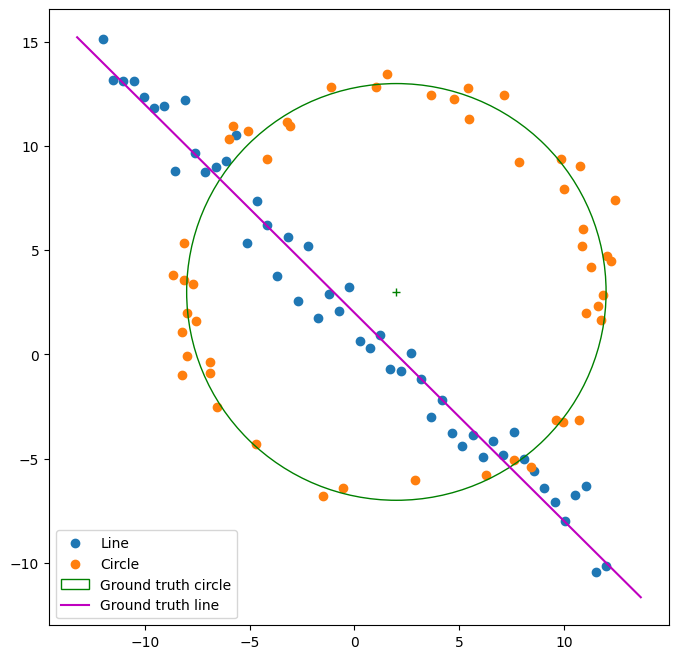

In [116]:
# np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3 # Center
s = r / 16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line)) # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')

ax.add_patch(circle_gt)
ax.plot([x0_gt], [y0_gt], '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])

y_ = m*x_ + b

plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()

plt.show()

The basic principle behind RANSAC is as follows:
- sample $N$ points randomly
- compute the parameters for the model using the sampled points
- count the number of inliers based on the model described by the above parameters and some specified threshold
- repeat $M$ times, so that we are at least $100\times p\%$ confident that we found at least one set of inliers
- report the parameters giving the most inliers as the best parameter estimates, if there are at least $T$ such inliers

We implement the above steps in the following function.

In [117]:
def RANSAC(data, num_samples, params_from_samples, error_given_params, inlier_thresh, iterations, min_inlier_count = 30):
    '''
    data is an array of tuples, each of num_samples elements
    min_inlier_count must be less than len(data)
    '''
    max_inlier_count = 0
    best_samples = None
    best_inliers = None
    best_params = None

    for _ in range(iterations):
        # Generate num_samples random integers between 0 and len(data), use these as indices to extract num_samples random samples from the data 
        sample_indices = np.random.randint(0, len(data), num_samples)
        samples = data[sample_indices]

        # Compute the model parameters using the above sampled points
        params = params_from_samples(samples)

        # Count the number of inliers based on the model described by the above parameters, and the specified threshold
        inliers = data[np.abs(error_given_params(params, data)) < inlier_thresh]
        
        # Keep track of which parameters produced the most inliers
        if ((len(inliers) > max_inlier_count)) and (len(inliers) >= min_inlier_count):
            max_inlier_count = len(inliers)
            best_samples = samples
            best_inliers = inliers
            best_params = params

    return best_samples, best_inliers, best_params

We will parameterize a straight line by $$x\cos\theta + y\sin\theta = d,$$ in terms of the parameters $\theta$ and $d$. Then, given two points $\left(x_1, y_1\right)$ and $\left(x_2, y_2\right)$ known to lie on the line, it can be shown that
$$
\theta = \arctan 2\left(x_2 - x_1, y_1 - y_2\right) \quad \text{and} \quad d = x_1 \cos\theta + y_1 \sin\theta.
$$
Further, given any point $(x, y)$, and a choice of parameters $\theta$ and $d$, we will consider the quantity $$\left|x\cos\theta + y\sin\theta - d\right|,$$ i.e., the perpendicular distance from the point to the line, as a measure of how well the model describes $(x, y)$. If it is smaller than some threshold, we will consider the point to be an inlier, and an outlier otherwise.

Functions to compute these quantities are implemented below for a straight line.

In [118]:
def line_params_from_samples(samples):
    x1, y1 = samples[0]
    x2, y2 = samples[1]

    theta = np.atan2((x2 - x1), (y1 - y2))
    d = x1*np.cos(theta) + y1*np.sin(theta)

    return (theta, d)

def line_error(params, data):
    theta, d = params
    x, y = data[:, 0], data[:, 1]

    return x*np.cos(theta) + y*np.sin(theta) - d

We will parameterize a circle by
$$
(x-h)^2 + (y-k)^2 = r^2,
$$
where $h$, $k$, $r$ are parameters.

This time, given three points $\left(x_1, y_1\right)$, $\left(x_2, y_2\right)$ and $\left(x_3, y_3\right)$ that lie on the line, it can be shown that
$$
h = \dfrac{B_2C_1 - B_1C_2}{A_1B_2 - A_2B_1}, \quad \text{and} \quad k = \dfrac{A_2C_1 - A_1C_2}{A_2B_1 - A_1B_2},
$$
where $A_1 = 2x_2-2x_1$, $A_2 = 2x_3 - 2x_1$, $B_1 = 2y_2 - 2y_1$, $B_2 = 2y_3 - 2y_1$, $C_1 = x_2^2 - x_1^2 + y_2^2 - y_1^2$ and $C_2 = x_3^2 - x_1^2 + y_3^2 - y_1^2$. Further, for these values of $h$ and $k$, we have
$$
r = \sqrt{\left(x_1 - h\right)^2 + \left(y_1 - k\right)^2}.
$$

Given an arbitrary point $(x, y)$ and the parameters $h$, $k$ and $r$, we will consider $$\left|r - \sqrt{\left(x - h\right)^2 + \left(y - k\right)^2}\right|,$$ the "radial error", as a measure of how well the model describes the point.

We implement the code to compute these quantities in the following function.

In [119]:
def circle_params_from_samples(samples):
    x1, y1 = samples[0]
    x2, y2 = samples[1]
    x3, y3 = samples[2]

    A1 = 2*(x2 - x1)
    A2 = 2*(x3 - x1)
    B1 = 2*(y2 - y1)
    B2 = 2*(y3 - y1)
    C1 = x2**2 - x1**2 + y2**2 - y1**2
    C2 = x3**2 - x1**2 + y3**2 - y1**2

    h = (B2*C1 - B1*C2) / (A1*B2 - A2*B1)
    k = (A2*C1 - A1*C2) / (A2*B1 - A1*B2)
    r = np.sqrt((x1 - h)**2 + (y1 - k)**2)

    return (h, k, r)

def circle_error(params, data):
    h, k, r = params
    x, y = data[:, 0], data[:, 1]

    return r - np.sqrt((x - h)**2 + (y - k)**2)

If it is known/assumed that the fraction of inliers in the data is $r$, the probability that the $N$ points sampled are not all inliers is $1-r^N$. The probability that this is the case in all $M$ repetitions is $\left(1 - r^N\right)^M$, and hence the probability that at we pick all inliers in at least one repetition is $1 - \left(1 - r^N\right)^M$.

We would like to have
$$
1 - \left(1 - r^N\right)^M > p,
$$
or equivalently,
$$
M > \dfrac{\ln\left(1 - p\right)}{\ln\left(1 - r^N\right)}.
$$

In our case, $r=0.5$ in both cases of the line and the circle. For $p=0.99$, then, we require in the case of the line ($N=2$) that
$$
M > \dfrac{\ln 0.01}{\ln\left(1 - 0.5^2\right)} > 16,
$$
and in the case of the circle ($N=3$) that
$$
M > \dfrac{\ln 0.01}{\ln\left(1 - 0.5^3\right)} > 34,
$$
if we do not remove the points chosen for the line when sampling points for the circle.

For better results in both cases, we will set $M = 1000$.

We then run RANSAC as described to find the best parameter estimates for the line and the circle.

In [120]:
line_best_samples, line_best_inliers, (theta_0, d_0) = RANSAC(X, 2, line_params_from_samples, line_error, 1, 1000)
a_0 = np.cos(theta_0)
b_0 = np.sin(theta_0)

remaining_points = np.array([x for x in X if x not in line_best_inliers])

circle_best_samples, circle_best_inliers, (h_0, k_0, r_0) = RANSAC(remaining_points, 3, circle_params_from_samples, circle_error, 1, 1000)

print ("RANSAC Estimates")
print()

print ("Line: ax + by = d")
print ("[with a^2 + b^2 = 1, i.e., a = cos(theta), b = sin(theta)]")
print()

print ("theta = {:0.2f} deg,".format(theta_0*180/np.pi), "d = {:0.2f}".format(d_0))
print ()

print ("{:0.2f}x + {:0.2f}y = {:0.2f}".format(a_0, b_0, d_0))

print("-" * 50)

print ("Circle: (x - h)^2 + (y - k)^2 = r^2")
print()

print ("h = {:0.2f},".format(h_0), "k = {:0.2f},".format(k_0), "r = {:0.2f}".format(r_0))
print ()

print ("(x - {:0.2f})^2 + (y - {:0.2f})^2 = {:0.2f}^2".format(h_0, k_0, r_0))

RANSAC Estimates

Line: ax + by = d
[with a^2 + b^2 = 1, i.e., a = cos(theta), b = sin(theta)]

theta = -136.69 deg, d = -1.52

-0.73x + -0.69y = -1.52
--------------------------------------------------
Circle: (x - h)^2 + (y - k)^2 = r^2

h = 1.62, k = 2.98, r = 10.01

(x - 1.62)^2 + (y - 2.98)^2 = 10.01^2


C:\Users\HP\AppData\Local\Temp\ipykernel_6312\2232126026.py:13: RuntimeWarning: invalid value encountered in scalar divide
  h = (B2*C1 - B1*C2) / (A1*B2 - A2*B1)
C:\Users\HP\AppData\Local\Temp\ipykernel_6312\2232126026.py:14: RuntimeWarning: invalid value encountered in scalar divide
  k = (A2*C1 - A1*C2) / (A2*B1 - A1*B2)


We will now use regression to try and better refine the model parameters found for the line and circle using only the found inliers. To do this, we must first define objective functions that must be optimized.

In [121]:
def line_cost(params, X):
    a, b, d = params

    x, y = X[:, 0], X[:, 1]

    return np.sum((x*a + y*b - d)**2)

def line_constraint(params):
    return params[0]**2 + params[1]**2 - 1

def circle_cost(params, X):
    h, k, r = params

    x, y = X[:, 0], X[:, 1]

    return np.sum((r - np.sqrt((x - h)**2 + (y - k)**2))**2)

The results of regression are as follows.

In [122]:
line_res = minimize(
    fun = line_cost, args = line_best_inliers,
    x0 = np.array([np.cos(theta_0), np.sin(theta_0), d_0]),
    constraints = {'type': 'eq', 'fun': line_constraint})

circle_res = minimize(
    fun = circle_cost, args = circle_best_inliers,
    x0 = np.array([h_0, k_0, r_0]))

a_1, b_1, d_1 = line_res.x
h_1, k_1, r_1 = circle_res.x

print ("Regression Estimates")
print()

print ("Line: ax + by = d")
print ("[with a^2 + b^2 = 1, i.e., a = cos(theta), b = sin(theta)]")
print()

print ("a = {:0.2f},".format(a_1), "b = {:0.2f},".format(b_1), "d = {:0.2f}".format(d_1))
print ()

print ("{:0.2f}x + {:0.2f}y = {:0.2f}".format(a_1, b_1, d_1))

print("-" * 50)

print ("Circle: (x - h)^2 + (y - k)^2 = r^2")
print()

print ("h = {:0.2f},".format(h_1), "k = {:0.2f},".format(k_1), "r = {:0.2f}".format(r_1))
print ()

print ("(x - {:0.2f})^2 + (y - {:0.2f})^2 = {:0.2f}^2".format(h_1, k_1, r_1))

Regression Estimates

Line: ax + by = d
[with a^2 + b^2 = 1, i.e., a = cos(theta), b = sin(theta)]

a = -0.72, b = -0.69, d = -1.46

-0.72x + -0.69y = -1.46
--------------------------------------------------
Circle: (x - h)^2 + (y - k)^2 = r^2

h = 1.76, k = 3.13, r = 9.99

(x - 1.76)^2 + (y - 3.13)^2 = 9.99^2


Now we will plot our results.

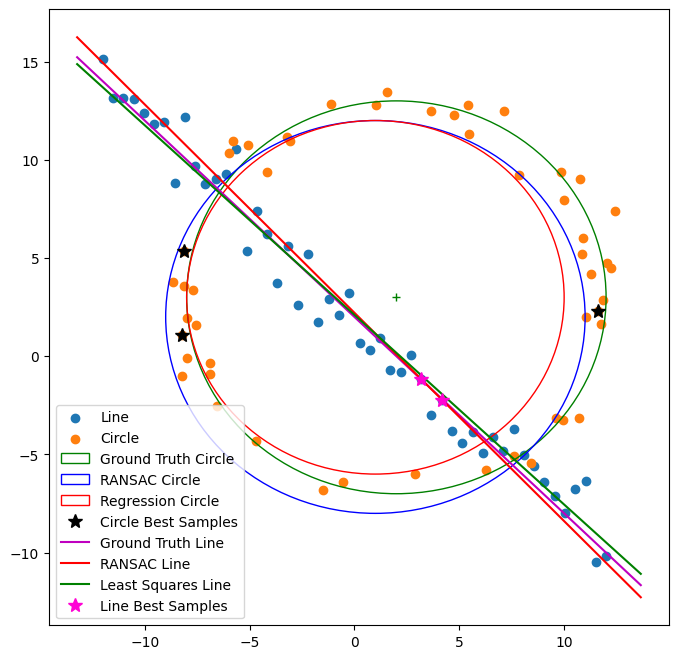

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Raw Data
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

# Circle

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot([x0_gt], [y0_gt], '+', color='g') # Center

circle_ransac = plt.Circle((int(h_0), int(k_0)), int(r_0), color='b', fill=False, label='RANSAC Circle')
ax.add_patch(circle_ransac)

circle_rg = plt.Circle((int(h_1), int(k_1)), int(r_1), color='r', fill=False, label='Regression Circle')
ax.add_patch(circle_rg)

# RANSAC sample that led to the best estimate of the circle parameters
ax.plot(circle_best_samples[:, 0], circle_best_samples[:, 1], '*', color="#000000", markersize=10, label='Circle Best Samples')

# Line

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])

y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground Truth Line')

y_ = -(a_0/b_0)*x_ + (d_0/b_0)
plt.plot(x_, y_, color='r', label='RANSAC Line')

y_ = -(line_res.x[1]/line_res.x[0])*x_ + (line_res.x[2]/line_res.x[1])
plt.plot(x_, y_, color='g', label='Least Squares Line')

# RANSAC samples that led to the best estimate of the line parameters
ax.plot(line_best_samples[:, 0], line_best_samples[:, 1], '*', color="#FF03D5", markersize=10, label='Line Best Samples')

plt.legend()
plt.show()

#### Question 03

Consider the capturing of an image of a planar surface, such as the facade of a building, with a camera.

Let $o$ be the origin, which we will interpret as the position of the camera. Let $\vec{i}$, $\vec{j}$ and $\vec{k}$ be the usual unit basis vectors, with $\vec{k}$ pointing out of the page.

Without loss of generality, let the image plane be a plane parallel to the $ij$ plane, at a distance $d$ into the page; so the image plane is spanned by $\vec{i}$ and $\vec{j}$. The position vector to the origin of the image plane would be $-d \vec{k}$.

Let $O = \left(O_x, O_y, O_z\right)$ be some point on the facade, that we interpret as the origin of a coordinate plane on its plane, and let $\vec{O} = O_x\vec{i} + O_y\vec{j} + O_z\vec{k}$ be the position vector to $O$ from $o$. Further, let $\vec{X}=X_x\vec{i} + X_y\vec{j} + X_z\vec{k}$ and $\vec{Y} = Y_x\vec{i} + Y_y\vec{j} + Y_z\vec{k}$ be two basis vectors spanning the facade.

Now, let $\lambda \vec{X} + \mu \vec{Y}$ be any point on the facade, i.e., the point which has coordinates $\left(\lambda, \mu\right)$ in the facade's coordinate system. The position vector to this point from $o$ is $\vec{O} + \lambda \vec{X} + \mu \vec{Y}$.

If $\lambda' \vec{i} + \mu'\vec{j}$ is the projection of the above point on to the image plane, then we require constants $\lambda'$, $\mu'$ and $\nu'$ such that
$$
\vec{O} + \lambda \vec{X} + \mu \vec{Y} = \nu \cdot \left(-d\vec{k} + \lambda' \vec{i} + \mu'\vec{j}\right).
$$

The above requirement is found to be represented component-wise in matrix form as
$$
\begin{bmatrix}
-dX_x & -dY_x & -dO_x \\
-dX_y & -dY_y & -dO_y \\
X_z & Y_z & O_z \\
\end{bmatrix}
\begin{bmatrix}
\lambda \\
\mu \\
1
\end{bmatrix}
=
\begin{bmatrix}
\nu \lambda' \\
\nu \mu' \\
\nu
\end{bmatrix},
$$
or more compactly as
$$
\mathbf{H} \mathbf{x} = \mathbf{y},
$$
where $\mathbf{H}$ denotes the above matrix, and is called the _homography matrix_, $\mathbf{x}$, the "homogeneous" coordinates of a point on the facade, and $\mathbf{y}$, of the corresponding point on the image plane.

If some point on the facade has coordinates $\left(\lambda, \mu\right)$, and the corresponding point on the image plane has coordinates $\left(\lambda', \mu'\right)$, then, there exists a matrix $\mathbf{H}$ with entries $h_{ij}$ satisfying
$$
-h_{11}\lambda + h_{31}\lambda'\lambda - h_{12}\mu + h_{32}\lambda'\mu - h_{13} + h_{33}\lambda' = 0 \\
-h_{21}\lambda + h_{31}\mu'\lambda - h_{22}\mu + h_{32}\mu'\mu - h_{23} + h_{33}\mu' = 0
$$
which, by letting $\mathbf{h} = \begin{bmatrix} h_{11} & h_{12} & h_{13} & h_{21} & h_{22} & h_{23} & h_{31} & h_{32} & h_{33} \end{bmatrix}^\top$ is equivalent to
$$
\begin{bmatrix}
-\lambda & -\mu & -1 & 0 & 0 & 0 & \lambda'\lambda & \lambda'\mu & \lambda' \\
0 & 0 & 0 & -\lambda & -\mu & -1 & \mu'\lambda & \mu'\mu & \mu'
\end{bmatrix}
\mathbf{h} = \mathbf{0},
$$
or
$$
\mathbf{A}\mathbf{h} = \mathbf{0},
$$
denoting the matrix on the left-hand side by $\mathbf{A}$.

As seen above, a single point correspondence gives 2 equations, leaving 7 degrees of freedom. Hence, with 4 point correspondences, we are left with only one degree of freedom.

A generic solution for any number of point correspondences can be found then, by minimizing $\lVert\mathbf{A}\mathbf{h}\rVert$, subject to the constraint that $\lVert\mathbf{h}\rVert=1$, i.e.,
$$
\mathbf{h}^* = \underset{\mathbf{h}}{\arg \min}\, \lVert\mathbf{A}\mathbf{h}\rVert,
\quad
\text{subject to}
\quad
\lVert\mathbf{h}\rVert = 1,
$$
which is equivalent to
$$
\underset{\mathbf{h}}{\arg \min}\, \left(\mathbf{A}\mathbf{h}\right)^\top \left(\mathbf{A}\mathbf{h}\right) - \lambda\left(\mathbf{h}^\top\mathbf{h} - 1\right)
=
\underset{\mathbf{h}}{\arg \min}\, \mathbf{h}^\top\left(\mathbf{A}^\top\mathbf{A}\right)\mathbf{h} - \lambda\left(\mathbf{h}^\top\mathbf{h} - 1\right).
$$

Differentiating with respect to $\mathbf{h}$, we obtain
$$
\mathbf{A}^\top\mathbf{A}\mathbf{h} = \lambda\mathbf{h},
$$
so $\lambda$ is an eigenvalue of $\mathbf{A}^\top\mathbf{A}$. Multiplying both sides by $\mathbf{h}^\top$, and imposing the constraint that $\mathbf{h}^\top\mathbf{h}=\lVert\mathbf{h}\rVert=1$, we finally see that
$$
\mathbf{h}^\top\mathbf{A}^\top\mathbf{A}\mathbf{h} = \lVert\mathbf{A}\mathbf{h}\rVert = \lambda \mathbf{h}^\top\mathbf{h} = \lambda,
$$
so the minimum value of $\lVert \mathbf{A}\mathbf{h} \rVert$ is the smallest eigenvalue of $\mathbf{A}^\top\mathbf{A}$, and $\mathbf{h}^*$ is the corresponding eigenvector.

We will solve by finding the SVD of $\mathbf{A}$, which is a more numerically stable computation than eigenvalue decomposition; i.e., we look for orthonormal $\mathbf{U}$, $\mathbf{\Sigma}$ with non-negative singular values along the diagonal, and orthonormal $\mathbf{V}$ such that
$$
\mathbf{A} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^\top.
$$
Then, because $\mathbf{U}^\top\mathbf{U}=\mathbf{V}^\top\mathbf{V}=\mathbf{I}$,
$$
\mathbf{A}^\top\mathbf{A} = \left(\mathbf{U}\mathbf{\Sigma}\mathbf{V}^\top\right)^\top\mathbf{U}\mathbf{\Sigma}\mathbf{V}^\top =
\mathbf{V}\left(\mathbf{\Sigma}^\top\mathbf{U}^\top\mathbf{U}\mathbf{\Sigma}\right)\mathbf{V}^\top
=
\mathbf{V}\left(\mathbf{\Sigma}^\top\mathbf{\Sigma}\right)\mathbf{V}^\top
=
\mathbf{V}\left(\mathbf{\Sigma}^\top\mathbf{\Sigma}\right)\mathbf{V}^{-1},
$$
which is precisely the eigendecomposition of $\mathbf{A}^\top\mathbf{A}$.

Hence, the eigenvector corresponding to the smallest eigenvalue of $\mathbf{A}^\top\mathbf{A}$ will be the last column of $\mathbf{V}$.

We now implement a function which performs exactly the procedure above, to compute a homography matrix based on 4 given point correspondences.

In [124]:
def compute_homography(correspondences):
    # Construct the matrix A as described above
    A = np.zeros((8, 9))
    for i, (src_pt, tgt_pt) in enumerate(correspondences):
        lamda, mu = src_pt
        lamda_,mu_ = tgt_pt
        A[2*i] = [-lamda, -mu, -1, 0, 0, 0, lamda*lamda_, mu*lamda_, lamda_]
        A[2*i + 1] = [0, 0, 0, -lamda, -mu, -1, lamda*mu_, mu*mu_, mu_]

    # Find the SVD of A
    _, _, Vt = linalg.svd(A)

    # The last column of V (row of Vt) is the solution
    H = Vt[-1, :].reshape((3, 3))

    return H

Suppose some planar shape is overlaid on a facade. If the dimensions of the planar shape are known, a convenient coordinate frame may be imposed on the facade, and the exact location and orientation of the shape on the facade described.

A convenient choice to describe a rectangular object being overlaid on a facade, is one where the rectangle's coordinates on the facade are exactly its dimensions.

For example, if a rectangular flag was overlaid on a facade, a natural choice for a coordinate frame for the facade, for a person looking straight at it (and not at an angle), would be the standard $xy$ coordinate system, with the origin placed at the bottom left corner of the flag, so that the coordinates of the corners of the flag are just its dimensions.

If an image is taken of the facade with the flag overlaid from a different perspective, the points on the image plane corresponding to the corners of the flag may be found using the image.

Using these correspondences, the relevant homography matrix can be computed.

Note that derivations above were made assuming (wlog) that the coordinate frame on the image frame is the standard $xy$ coordinate frame, so all points on the image plane must be described accordingly.

We use this principle to construct the following function to overlay a given image on another.

In [125]:
def overlay_img(base_img, overlay_img, correspondences):
    # Use the function derived above to compute the homograhy matrix using the given correspondences
    H = compute_homography(correspondences)

    # Apply the homography to the image to be overlaid, and get a new image of the same shape as the base image
    warped_overlay = cv2.warpPerspective(overlay_img, H, (base_img.shape[1], base_img.shape[0]))

    # Extract the target points (coordinates of the corners of the quadrilateral that the overlay image must land on)
    tgt_pts = np.array([tgt_pt for (_, tgt_pt) in correspondences])

    # Construct a copy of the base image to avoid modifying the original
    base_img = base_img.copy()

    # Black out the area of the above quadrilateral in the base image to overlay the warped image there
    cv2.fillConvexPoly(base_img, tgt_pts, (0, 0, 0))

    # Add the warped overlay image to the base image
    final_img = cv2.add(base_img, warped_overlay)

    return final_img

We will now show two demonstrations of this.

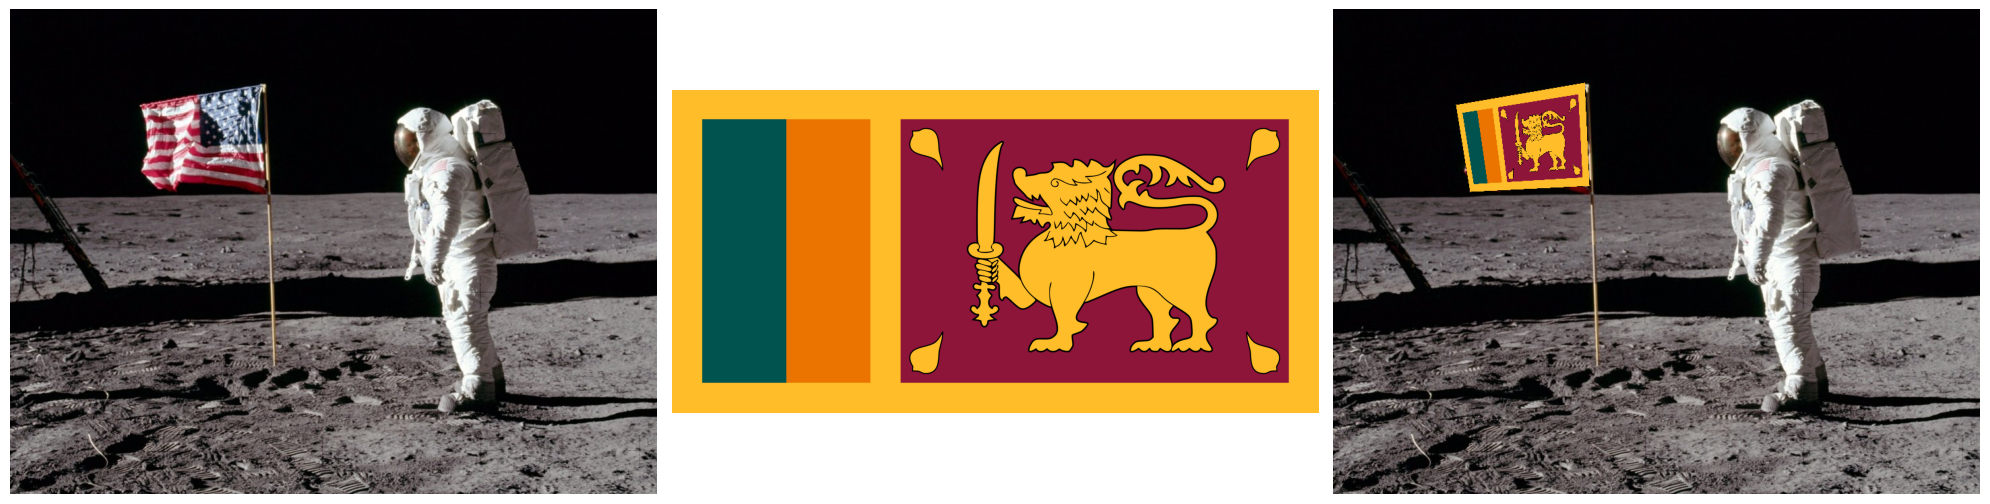

In [126]:
# Import the images; overlay image and base image
flag = cv2.imread("slflag.png")
moon = cv2.imread("moonland.jpg")

h_flag, w_flag, _ = flag.shape
h_moon, w_moon, _ = moon.shape

flag_corners = np.array([
    [0, 0],           [0, h_flag - 1],      [w_flag - 1, h_flag - 1],   [w_flag - 1, 0]
])

# Chosen by clicking on the desired points on the image
warped_flag_corners = np.array([
    [182, 142],       [203, 271],           [380, 262],                 [373, 109]
])

correspondences = np.array([(flag_corners[i], warped_flag_corners[i]) for i in range(len(flag_corners))])

final_image = overlay_img(moon, flag, correspondences)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for a in ax:
    a.axis('off')

ax[0].imshow(cv2.cvtColor(moon, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(flag, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()

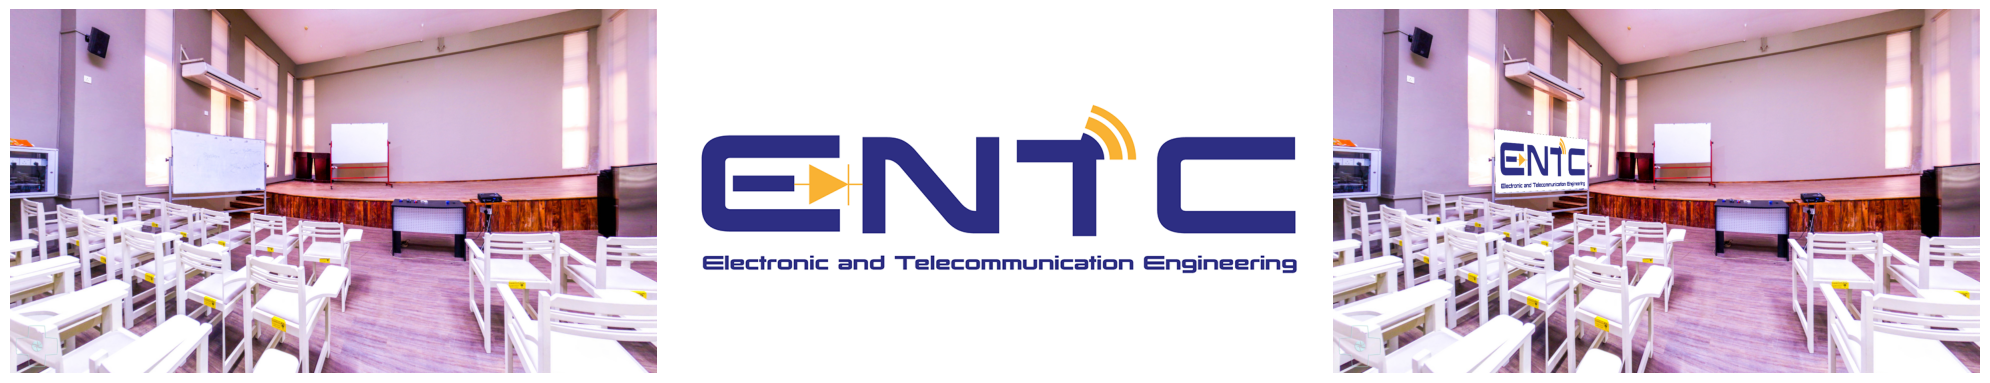

In [127]:
# Import the images; overlay image and base image
entclogo = cv2.imread("entclogo.png")
entc1 = cv2.imread("entc1.png")

h_logo, w_logo, _ = entclogo.shape
h_entc1, w_entc1, _ = entc1.shape

logo_corners = np.array([
    [0, 0],           [0, h_logo - 1],      [w_logo - 1, h_logo - 1],   [w_logo - 1, 0]
])

# Chosen by clicking on the desired points on the image
warped_logo_corners = np.array([
    [479, 356],       [482, 545],           [754, 531],                 [754, 387]
])

correspondences = np.array([(logo_corners[i], warped_logo_corners[i]) for i in range(len(logo_corners))])

final_image = overlay_img(entc1, entclogo, correspondences)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for a in ax:
    a.axis('off')

ax[0].imshow(cv2.cvtColor(entc1, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(entclogo, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()

#### Question 04

We start by loading both images.

In [128]:
im1 = cv2.imread("graf/img1.ppm")
im2 = cv2.imread("graf/img3.ppm")

im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

We then extract SIFT features from the images, find pairs of the best matching points across the images, and construct a vector of these points.

In [129]:
# Find SIFT features from the images
sift = cv2.SIFT_create()

src_kp, src_des = sift.detectAndCompute(im1, None)
tgt_kp, tgt_des = sift.detectAndCompute(im2, None)

# Use BFMatcher to match the SIFT features across the images
bf = cv2.BFMatcher()
matches = bf.knnMatch(src_des, tgt_des, k=2)

# Pick out the best matches based on Lowe's Ratio test
matches = [m for (m, n) in matches if m.distance < 0.75*n.distance]
print (len(matches), "matches found.")

# Extract the coordinates of the source and target points corresponding to the best matches
src_pts = np.array([src_kp[m.queryIdx].pt for m in matches], dtype=np.float32)
tgt_pts = np.array([tgt_kp[m.trainIdx].pt for m in matches], dtype=np.float32)

# Construct a vector with source and corresponding target points
X = np.array([(src_pts[i], tgt_pts[i]) for i in range(len(src_pts))])

520 matches found.


It turns out that the mapping from the first image to the second can also be represented by a matrix.

To see this, suppose $\mathbf{x}$ gives the homogeneous coordinates of some point in some coordinate frame placed on the plane of the facade.

The homogeneous coordinates of the corresponding point in the plane of the first image, say $\mathbf{y}_1$, would be given by $\mathbf{y}_1 = \mathbf{H}_1\mathbf{x}$, where $\mathbf{H}_1$ is the relevant homography matrix.

The homogeneous coordinates of the _same_ point on the facade in the plane of the second image, say $\mathbf{y}_2$ would be given by $\mathbf{y}_2 = \mathbf{H}_2\mathbf{x}$, where $\mathbf{H}_2$ is a different homography matrix. But then we have
$$
\mathbf{x} = \mathbf{H}_1^{-1}\mathbf{y_1}, \quad\text{so that}\quad
\mathbf{y}_2 = \mathbf{H}_2\mathbf{x} = \left(\mathbf{H}_2 \mathbf{H}_1^{-1}\right) \mathbf{y}_1 = \mathbf{H}_3\mathbf{y}_1,
$$
a representation of the mapping between the points expressed in terms of a matrix $\mathbf{H}_3$, called a _homography matrix_ in this context too.

We shall use the RANSAC algorithm implemented above to estimate the best homography matrix relating the images.

For this, we first construct the relevant functions that must be passed to the `RANSAC` function implemented above.

`compute_homography` above already computes the "model parameters" (in this case, the homography matrix) using some given samples, so we need only implement a function to compute the "error" given some model. We will use the squared 2-norm of the difference between the point that the matrix transforms a given source point to, and the actual corresponding target point as a measure of error.

In [130]:
def homography_error(H, data):
    src_pts, tgt_pts = data[:, 0], data[:, 1]

    src_pts_hmg = np.hstack((src_pts, np.ones((src_pts.shape[0], 1))))
    predicted_pts_hmg = H @ src_pts_hmg.T
    predicted_pts = (predicted_pts_hmg[:2, :] / predicted_pts_hmg[2, :]).T
    
    return np.linalg.norm(predicted_pts - tgt_pts, axis=1)

Now, we run `RANSAC`. To estimate the number of iterations required, we will use the formula we derived above. Here, $N=4$, and setting $p=0.9$ and underestimating $r$ by considering the extreme case of just one inlier among all found matches, we get:

In [131]:
N = 4
p = 0.9
r = 1 / len(matches)
M = int(np.log(1 - p) / np.log(1 - r**N))
print ("Estimated no. of iterations: >", M)

Estimated no. of iterations: > 168356544633


which is an extremely huge number. On the other hand, given a number of iterations, say, $M=5000$, we can estimate the expected inlier ratio to have $p=0.9$ probability of finding at least one set of inliers. This number is:

In [132]:
M = 5000
r = np.pow(1 - np.pow(1-p, 1/M), 1/N)
print ("Expected inlier ratio: <", r)
print ("Fewer than %d inliers among all %d matches found" % (int(r*len(matches)), len(matches)))

Expected inlier ratio: < 0.1464827288973755
Fewer than 76 inliers among all 520 matches found


which might be considered a reasonable number. Hence, we will run `RANSAC` with 5000 or more iterations.

In [133]:
# Compute a homography estimate with RANSAC
homography_best_samples, homography_best_inliers, H_0 = RANSAC(X, 4, compute_homography, homography_error, 200, M, min_inlier_count=5)

# Normalize by dividing by the last entry
H_0 /= H_0[2, 2]

print ("RANSAC Homography Estimate")
for row in H_0:
    print(" ".join(f"{val:10.4f}" for val in row))

RANSAC Homography Estimate
    0.3700    -0.2633   200.7480
   -0.0717     0.3372   162.5262
   -0.0003    -0.0005     1.0000


We will refine our estimate by now performing regression on the estimated matrix, using only the best inliers discovered.

Next, we will define a function to stitch together two images related by some homography matrix. For this, we construct the relevant objective function to be minimized as follows.

In [134]:
def homography_cost(params, X):
    # The minimizer expects arguments passed as a vector (1D array), so construct the matrix out of such a vector
    H = params.reshape((3, 3))

    # Use the homography_error function defined above to compute the error due to this matrix, and average over all points
    return np.sum(homography_error(H, X)) / (len(X))

Finally, we find the best matrix that minimizes this cost.

In [135]:
homography_res = minimize(
    fun = homography_cost, args = homography_best_inliers,
    x0 = H_0.flatten())

H_1 = homography_res.x.reshape(3, 3) # Reshape as a matrix
H_1 = H_1 / H_1[2, 2] # Normalize so last entry is 1

print ("Regression Homography Estimate")
for row in H_1:
    print(" ".join(f"{val:10.4f}" for val in row))

Regression Homography Estimate
    0.7584    -0.2825   223.7093
    0.3293     1.0319   -78.8760
    0.0003     0.0000     1.0000


The following is the ground-truth homography, for comparison.

In [136]:
H_gt = np.loadtxt("graf/H1to3p").reshape(3, 3)

print ("Ground Truth Homography")
for row in H_gt:
    print(" ".join(f"{val:10.4f}" for val in row))

Ground Truth Homography
    0.7629    -0.2992   225.6712
    0.3344     1.0144   -77.0000
    0.0003    -0.0000     1.0000


Note that digital images have restricted coordinate axes, i.e., they do not extend to infinity (there can very well exist coordinates outside them; they would simply not be visible on the digital image). When an image is warped onto another image, it is possible therefore that some parts of the warped image land outside the axis limits on the other one.

In other words, if $I_1$ is the image we wish to overlay, and $I_2$ is the base image, i.e., the image on which we wish to overlay $I_1$ (as described by $\mathbf{H}$, say), then coordinates of $I_1$ in $I_2$ may exceed the limits of $I_2$'s coordinate axes.

To address this, we construct another image $I_3$, with suitably extended dimensions, such that transforming points in $I_2$ on to it, including especially those that exceed $I_2$'s axis limits, land within the axis limits of $I_3$.

Now we are free to choose where we want the origin of $I_3$ to be, and for programming convenience, we will place it at the bottom left corner. The required transformation is just a translation (it is only a shift of origin to a new location on the _same_ plane), and can also be described by a homography matrix.

If the origin must move to the point $(X, Y)$ in $I_2$'s coordinates, then the required homography matrix is
$$
\mathbf{T}
=
\begin{bmatrix}
-d & 0 & -dX \\
0 & -d & -dY \\
0 & 0 & -d \\
\end{bmatrix}
\sim
\begin{bmatrix}
1 & 0 & X \\
0 & 1 & Y \\
0 & 0 & 1 \\
\end{bmatrix},
$$
according to the form of such a matrix as described above.

Thus, $I_1$ must first be transformed by $\mathbf{H}$, and then by $\mathbf{T}$; or equivalently by $\mathbf{T}\mathbf{H}$, while $I_2$ need only be transformed by $\mathbf{T}$, to get the corresponding points on $I_3$.

We will now define a function which implements the above.

In [141]:
def stitch(im1, im2, H):
    # Find the extreme corner coordinates of both images
    h1, w1 = im1.shape
    h2, w2 = im2.shape

    # We shall transform the corners of im1 to their corresponding locations in im2 first; because the rest of the image obviously lies within these corners.
    # We choose the bottom-left corners of both images as the origins of their respective coordinate systems.
    im1_corners = np.array([[0, 0], [w1, 0], [w1, h1], [0, h1]], dtype=np.float32).T
    im1_corners_hmg = np.vstack((im1_corners, np.ones((1, 4))))
    im1_corners_in_im2_hmg = H @ im1_corners_hmg
    im1_corners_in_im2 = im1_corners_in_im2_hmg[:2, :] / im1_corners_in_im2_hmg[2, :]

    # We now look for the extreme corners when im1 is transformed onto im2's coordinate frame.
    leftmost_x = int(min(0, np.min(im1_corners_in_im2[0, :])))
    rightmost_x = int(max(w2, np.max(im1_corners_in_im2[0, :])))
    bottommost_y = int(min(0, np.min(im1_corners_in_im2[1, :])))
    topmost_y = int(max(h2, np.max(im1_corners_in_im2[1, :])))

    # Find the dimensions of the stitched image, im3
    w3 = rightmost_x - leftmost_x
    h3 = topmost_y - bottommost_y

    # im3 now, is an h3 x w3 plane
    
    # Define the translation matrix from im2 to im3
    T = np.array([
        [1, 0, -leftmost_x],
        [0, 1, -bottommost_y],
        [0, 0, 1]
    ], dtype=np.float32)

    # Apply the resultant homography to im1, and produce an image of im3's size
    im1_warped = cv2.warpPerspective(im1, T @ H, (w3, h3))

    # Obtain a mask of im1 in im3's coordinate system; transform a rectangle shaped like im1 to im3
    mask = cv2.warpPerspective(np.ones_like(im1), T @ H, (w3, h3))

    # Start constructing im3 by translating im2 in its correct location
    im3 = cv2.warpPerspective(im2, T, (w3, h3))

    # Black out the area where im1 will land on, in im3
    im3[mask == 1] = 0

    # Add the warped im1 to im3
    im3 = im3 + im1_warped

    return im3, im1_warped

We can now stitch together the images using the best homography matrix found by regression, and plot them for comparison.

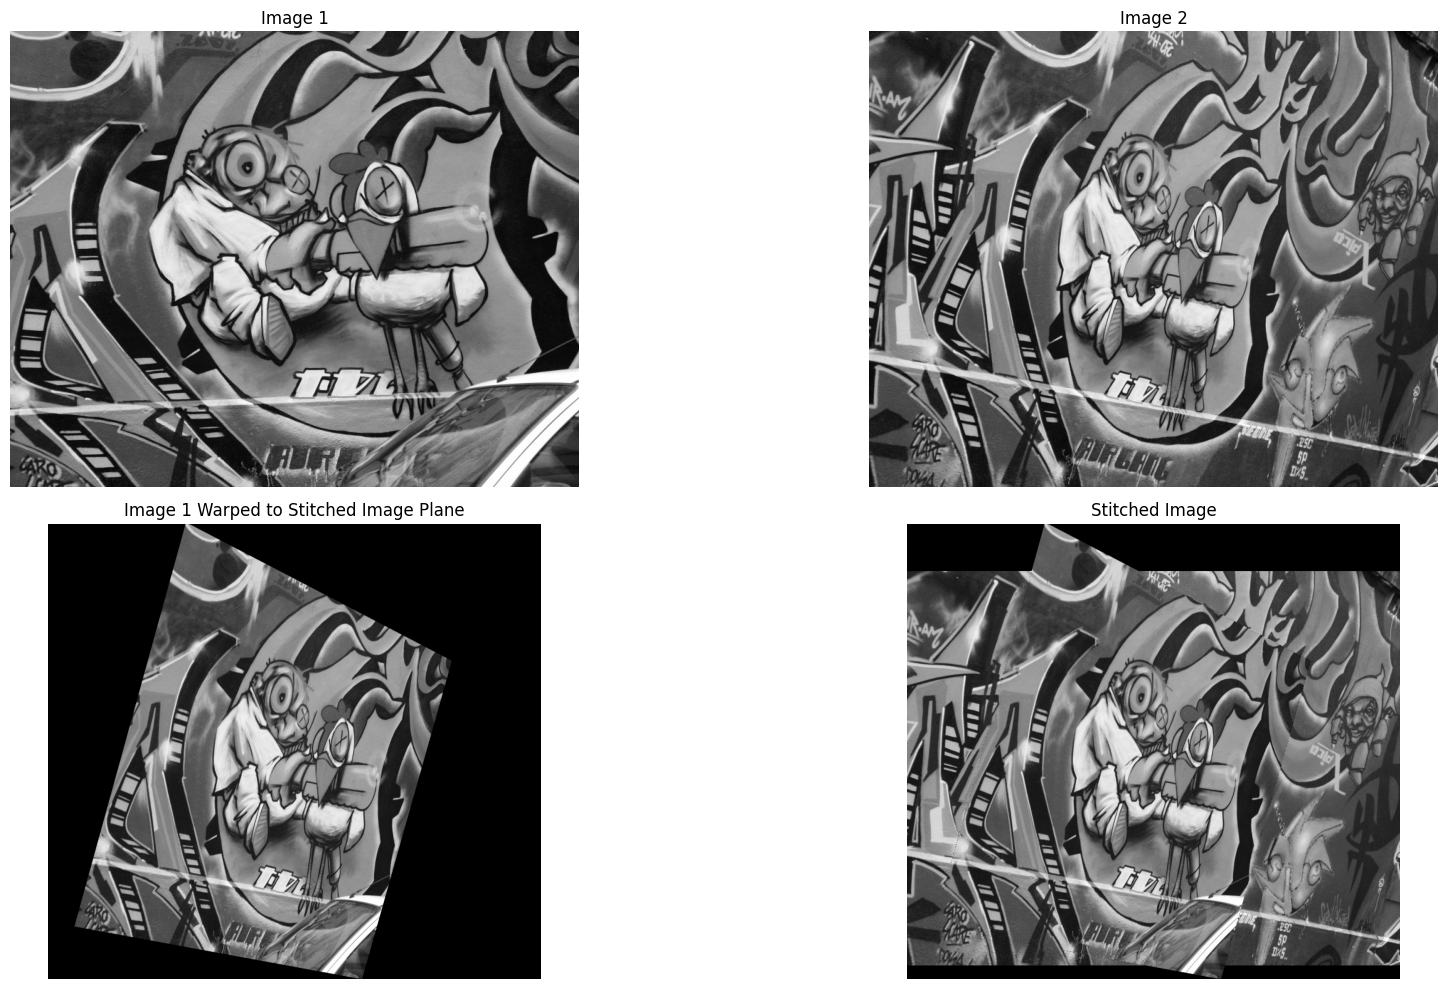

In [144]:
stitched, im1_warped = stitch(im1, im2, H_1)

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for a in ax.flatten():
    a.axis('off')

ax[0][0].imshow(im1, cmap='gray')
ax[0][0].set_title("Image 1")

ax[0][1].imshow(im2, cmap='gray')
ax[0][1].set_title("Image 2")

ax[1][0].imshow(im1_warped, cmap='gray')
ax[1][0].set_title("Image 1 Warped to Stitched Image Plane")

ax[1][1].imshow(stitched, cmap='gray')
ax[1][1].set_title("Stitched Image")

plt.tight_layout()
plt.show()